In [3]:
import pandas as pd
import regex, re, sys, nltk

from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

from collections import Counter

import matplotlib.pyplot as plt

from pathlib import Path

src_path = str(Path.cwd().parent / "src")
sys.path.append(src_path)
# python file with all the functions (located in the src folder)
import topic_classification as tc

In [4]:
filepath = Path.cwd().parent / "speeches_csv" / "all_speeches_cleaned.txt"
df=pd.read_csv(filepath, usecols=['title','content'])
df.head()

,title,content
0,CGI_2013,Hillary Clinton: Thank you very much. I have t...
1,Prayer_Breakfast_2016,"Well, good morning. Giving all praise and hono..."
2,Security_Team_Announcement,"Good morning, everybody. I hope you all had a ..."
3,Cairo_University,Thank you so much. Good afternoon. I am honore...
4,Umpqua_Community_College_Shootings,There's been another mass shooting in America ...


In [5]:
df['text']=df['content'].str.lower()
df.head()

,title,content,text
0,CGI_2013,Hillary Clinton: Thank you very much. I have t...,hillary clinton: thank you very much. i have t...
1,Prayer_Breakfast_2016,"Well, good morning. Giving all praise and hono...","well, good morning. giving all praise and hono..."
2,Security_Team_Announcement,"Good morning, everybody. I hope you all had a ...","good morning, everybody. i hope you all had a ..."
3,Cairo_University,Thank you so much. Good afternoon. I am honore...,thank you so much. good afternoon. i am honore...
4,Umpqua_Community_College_Shootings,There's been another mass shooting in America ...,there's been another mass shooting in america ...


In [6]:
# tokenize into sentences
df['tokenized']=df['text'].apply(lambda text: nltk.sent_tokenize(text))
df[['text','tokenized']].head()

,text,tokenized
0,hillary clinton: thank you very much. i have t...,"[hillary clinton: thank you very much., i have..."
1,"well, good morning. giving all praise and hono...","[well, good morning., giving all praise and ho..."
2,"good morning, everybody. i hope you all had a ...","[good morning, everybody., i hope you all had ..."
3,thank you so much. good afternoon. i am honore...,"[thank you so much., good afternoon., i am hon..."
4,there's been another mass shooting in america ...,[there's been another mass shooting in america...


In [7]:
# the '\b(?!\d)' filters out expressions like '9th', since the first character cannot be a number
tokenizer = RegexpTokenizer(r'\b(?!\d)[a-zA-Z]+')
lemmatizer = WordNetLemmatizer()
df['normalized']=df['tokenized'].apply(lambda text: tc.normalize_text(text, tokenizer, lemmatizer))
df[['text','tokenized','normalized']].head()

,text,tokenized,normalized
0,hillary clinton: thank you very much. i have t...,"[hillary clinton: thank you very much., i have...",hillary clinton thank you very much i have th...
1,"well, good morning. giving all praise and hono...","[well, good morning., giving all praise and ho...",well good morning give all praise and honor t...
2,"good morning, everybody. i hope you all had a ...","[good morning, everybody., i hope you all had ...",good morning everybody i hope you all have a ...
3,thank you so much. good afternoon. i am honore...,"[thank you so much., good afternoon., i am hon...",thank you so much good afternoon i be honor t...
4,there's been another mass shooting in america ...,[there's been another mass shooting in america...,there s be another mass shooting in america t...


In [8]:
STOPWORDS = set(stopwords.words('english'))
df['fully_processed'] = df['normalized'].apply(lambda text: tc.remove_stopwords(text, STOPWORDS))
                
cnt = Counter()
for text in df['fully_processed'].values:
    # counts the number of speeches the word is in
    for word in set(text.split()):
        cnt[word] += 1
# words that are in most of the speeches
in_most_speeches = cnt.most_common(155)
in_most_speeches = [x[0] for x in in_most_speeches]

extra = ['mr', 'question', 'sure', 'obama', 'really', 'try', 'lot', 'important', 'million', 'talk', 'va', 'dr', 'romney',
        'folk', 'governor', 'republican', 'king', 'heart'] 

STOPWORDS_extra = set(in_most_speeches + extra)
# remove some words from the stopwords list that migth be important
STOPWORDS_extra = STOPWORDS_extra - set(['war', 'care', 'child', 'family', 'job', 'law', 'protect', 'security', 'power'])

df['fully_processed'] = df['fully_processed'].apply(lambda text: tc.remove_stopwords(text, STOPWORDS_extra))
df[['text','tokenized','normalized','fully_processed']].head()

,text,tokenized,normalized,fully_processed
0,hillary clinton: thank you very much. i have t...,"[hillary clinton: thank you very much., i have...",hillary clinton thank you very much i have th...,hillary clinton pleasure introduce speaker con...
1,"well, good morning. giving all praise and hono...","[well, good morning., giving all praise and ho...",well good morning give all praise and honor t...,morning praise honor god morning everyone orga...
2,"good morning, everybody. i hope you all had a ...","[good morning, everybody., i hope you all had ...",good morning everybody i hope you all have a ...,morning wonderful thanksgiving announce econom...
3,thank you so much. good afternoon. i am honore...,"[thank you so much., good afternoon., i am hon...",thank you so much good afternoon i be honor t...,afternoon honor timeless city cairo host remar...
4,there's been another mass shooting in america ...,[there's been another mass shooting in america...,there s be another mass shooting in america t...,mass shooting college oregon family mom dad ch...


In [16]:
tf_vectorizer = CountVectorizer(stop_words='english', min_df=3, max_df=0.85, ngram_range=(1, 2), max_features=5000)
tf_matrix = tf_vectorizer.fit_transform(df['fully_processed'])

search_params = {
  'n_components': [5, 10, 12, 15, 20, 25, 30, 35]
}

# if the data size is large, the online update will be much faster than the batch update
model = LatentDirichletAllocation() # learning_method='online'

# Try all of the options
gridsearch = GridSearchCV(model, param_grid=search_params, n_jobs=-1, verbose=2)
gridsearch.fit(tf_matrix)

print("Best Model's Params: ", gridsearch.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Model's Params:  {'n_components': 5}


In [25]:
lda = LatentDirichletAllocation(n_components=10,random_state=0) # 25
tf_vectorizer = CountVectorizer(stop_words='english', min_df=3, max_df=0.85, ngram_range=(1, 3), max_features=5000)
tf_matrix = tf_vectorizer.fit_transform(df['fully_processed'])
tf_feature_names = tf_vectorizer.get_feature_names_out()
tf_df = pd.DataFrame(tf_matrix.toarray(), columns = tf_feature_names)
tf_df

,abadi,abandon,abe,abide,ability,abraham,abraham lincoln,abroad,absence,absolute,...,yes,yes yes,yesterday,yield,york,york city,youth,zero,zika,zone
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,2,3,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
433,0,1,0,0,1,0,0,0,0,0,...,8,0,0,1,0,0,2,0,4,0
434,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [26]:
lda.fit(tf_matrix) 
result = pd.DataFrame(lda.components_)
result.columns = tf_feature_names
result

,abadi,abandon,abe,abide,ability,abraham,abraham lincoln,abroad,absence,absolute,...,yes,yes yes,yesterday,yield,york,york city,youth,zero,zika,zone
0,0.100001,6.295437,0.100209,2.944600,23.714837,0.520098,0.100045,30.026864,5.398880,0.100023,...,29.031465,0.100012,1.617904,2.522388,16.267561,8.773430,33.618181,11.065335,5.293145,0.100012
1,0.100192,2.150114,0.100004,26.536500,35.473951,0.100008,0.100004,7.925377,2.032056,4.416859,...,4.898301,0.100041,4.826131,4.963315,12.189623,3.486409,0.100007,0.100039,0.100020,0.100030
2,17.410564,13.253775,0.100002,0.100032,29.713724,0.100003,0.100004,2.935043,5.431046,0.100053,...,6.485888,0.100000,38.365094,0.100022,0.272987,0.100059,0.100011,0.100030,0.100054,25.453229
3,0.100009,0.100023,0.100052,18.927553,0.431094,0.100008,0.100004,0.100007,1.990503,1.165936,...,43.599191,0.567756,2.313869,1.617517,10.547346,0.100044,7.568899,0.100197,16.906707,1.533443
4,0.100000,5.909023,0.100077,0.104572,31.935176,23.778235,19.247733,11.380784,4.771568,0.100030,...,129.115095,23.361761,4.453814,4.424738,25.094428,9.730544,5.446429,6.831739,0.100004,0.120370
5,0.100002,7.705737,0.100001,0.100017,25.304398,0.100003,0.100003,5.697499,1.841074,1.693912,...,81.174293,5.724006,24.868129,0.277296,19.556573,0.900298,1.460584,0.100026,0.100032,0.100044
6,0.100004,1.552242,0.100000,10.639192,27.498530,1.824550,2.477138,0.100017,0.100021,1.838794,...,93.011591,7.163615,32.979125,2.223805,9.969899,0.330093,0.100002,11.395966,0.100004,0.100012
7,0.100000,6.864779,0.100091,4.722236,20.600061,0.918443,1.575029,50.976767,9.308789,10.662686,...,25.186563,0.100013,24.391244,3.893687,12.392711,4.379038,6.151042,6.308521,0.100004,7.394923
8,2.789223,8.068829,0.100002,10.905021,35.749163,2.458639,0.100025,0.100016,12.026050,1.437237,...,9.466751,0.100005,31.613633,0.100023,4.606616,0.100049,0.118014,7.898103,0.100010,0.100014
9,0.100004,0.100042,33.099561,26.020278,37.579066,0.100014,0.100016,4.757626,0.100013,3.484471,...,55.030862,2.682792,38.571058,6.877209,0.102256,0.100036,31.336831,0.100045,0.100020,5.997924


['faith', 'muslim', 'child', 'freedom', 'human', 'democracy', 'power', 'justice', 'violence', 'law']
['law', 'court', 'intelligence', 'problem', 'security', 'process', 'russia', 'case', 'election', 'political']
['isil', 'syria', 'terrorist', 'military', 'iraq', 'security', 'attack', 'partner', 'threat', 'russia']
['gun', 'law', 'family', 'violence', 'kid', 'child', 'congress', 'police', 'check', 'criminal']
['job', 'school', 'family', 'child', 'college', 'economy', 'education', 'business', 'student', 'generation']
['business', 'company', 'cuban', 'cuba', 'job', 'economy', 'oil', 'problem', 'energy', 'vietnam']
['health', 'care', 'tax', 'insurance', 'job', 'health care', 'business', 'pay', 'cut', 'plan']
['war', 'family', 'serve', 'veteran', 'afghanistan', 'military', 'iraq', 'troop', 'god', 'service']
['iran', 'nuclear', 'israel', 'weapon', 'deal', 'nuclear weapon', 'security', 'peace', 'sanction', 'international']
['region', 'china', 'democracy', 'asia', 'human', 'economy', 'trade', '

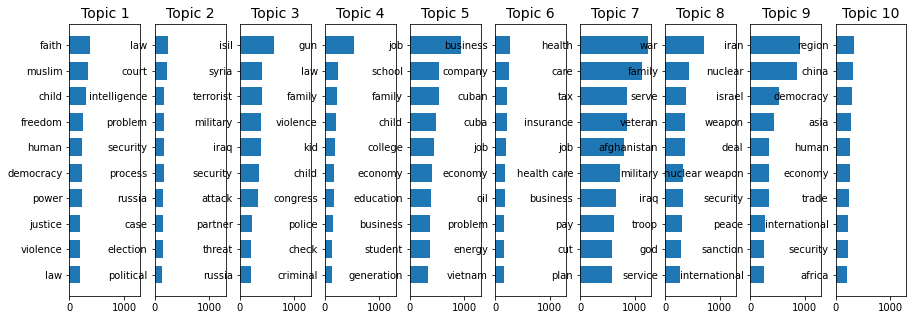

In [27]:
n_top_words = 10
fig, axes = plt.subplots(1, lda.n_components, figsize=(15, 5), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [tf_feature_names[i] for i in top_features_ind]
    print(top_features)
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=10)

In [11]:
classification_df = tc.classify_topics(lda, tf_matrix, df.title.values)
classification_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,title
0,0.004650,0.004650,0.004650,0.004650,0.004650,0.004650,99.958150,0.004650,0.004650,0.004650,CGI_2013
1,66.196996,0.013213,0.013213,1.070205,5.536665,0.013213,0.013213,25.346006,1.784063,0.013213,Prayer_Breakfast_2016
2,0.015629,27.173781,18.159463,0.015629,0.015630,3.309813,0.015629,34.372995,10.973940,5.947490,Security_Team_Announcement
3,51.422055,1.760718,0.005579,0.005579,0.502934,0.005579,0.005579,12.836602,23.183000,10.272377,Cairo_University
4,0.027939,0.027940,0.027940,99.748549,0.027939,0.027939,0.027941,0.027940,0.027937,0.027938,Umpqua_Community_College_Shootings
...,...,...,...,...,...,...,...,...,...,...,...
431,0.007521,0.007520,4.129072,0.007520,10.543076,9.357602,0.007521,0.007521,0.007520,75.925125,ASEAN_Business_2015
432,0.026604,0.026602,0.026606,0.026600,58.041795,5.587060,36.184926,0.026602,0.026603,0.026601,Finance_Crisis_Fee
433,5.821842,0.005122,0.005121,9.910704,9.005705,50.553674,7.181815,0.005122,6.194109,11.316787,YLAI_Town_Hall
434,29.042974,0.014623,56.483995,6.674099,0.014623,0.014623,0.014622,7.711195,0.014623,0.014622,Oval_Office_Counter_Terrorism_Agenda


In [12]:
tc.nb_topics_above_percentage(classification_df, 10)
tc.nb_topics_above_percentage(classification_df, 20)

print('nb topics above 10%')
print('min:', classification_df.loc[:,"nb_topics_above_10_percent"].min())
print('avg:', classification_df.loc[:,"nb_topics_above_10_percent"].mean())
print('max:', classification_df.loc[:,"nb_topics_above_10_percent"].max())
print(f'on average a speech has {classification_df.loc[:,"nb_topics_above_10_percent"].mean():.0f} topics above 10%')

print('\nnb topics above 20%')
print('min:', classification_df.loc[:,"nb_topics_above_20_percent"].min())
print('avg:', classification_df.loc[:,"nb_topics_above_20_percent"].mean())
print('max:', classification_df.loc[:,"nb_topics_above_20_percent"].max())
print(f'on average a speech has {classification_df.loc[:,"nb_topics_above_20_percent"].mean():.0f} topics above 20%')

nb topics above 10%
min: 1
avg: 2.330275229357798
max: 6
on average a speech has 2 topics above 10%

nb topics above 20%
min: 1
avg: 1.614678899082569
max: 4
on average a speech has 2 topics above 20%


In [13]:
topics_df = pd.DataFrame()
nb_speeches = classification_df.shape[0]
tc.percentage_speeches_above_percentage(10, nb_speeches, classification_df, topics_df)
tc.percentage_speeches_above_percentage(20, nb_speeches, classification_df, topics_df)
topics_df

,percentage_speeches_above_10_percent,percentage_speeches_above_20_percent
Topic 1,29.357798,19.724771
Topic 2,16.743119,9.862385
Topic 3,19.495413,13.990826
Topic 4,15.137615,7.798165
Topic 5,41.513761,31.880734
Topic 6,20.412844,15.366972
Topic 7,23.853211,18.348624
Topic 8,36.009174,25.000000
Topic 9,13.302752,8.256881
Topic 10,17.201835,11.238532


In [14]:
select = classification_df.columns.str.startswith("Topic ")
topics_df['overall_percentage'] = classification_df.loc[:, select].sum(axis=0) / nb_speeches
topics_df.sort_values(by='overall_percentage', ascending=False)

,percentage_speeches_above_10_percent,percentage_speeches_above_20_percent,overall_percentage
Topic 5,41.513761,31.880734,19.137390
Topic 8,36.009174,25.000000,15.449487
Topic 7,23.853211,18.348624,12.338187
Topic 1,29.357798,19.724771,10.436265
Topic 6,20.412844,15.366972,8.897800
Topic 3,19.495413,13.990826,8.866551
Topic 10,17.201835,11.238532,6.768524
Topic 2,16.743119,9.862385,6.167609
Topic 9,13.302752,8.256881,6.013176
Topic 4,15.137615,7.798165,5.925012


In [15]:
tc.sum_of_n_largest(2, classification_df)
tc.sum_of_n_largest(3, classification_df)
tc.sum_of_n_largest(4, classification_df)
classification_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,title,nb_topics_above_10_percent,nb_topics_above_20_percent,sum_of_2_largest,sum_of_3_largest,sum_of_4_largest
0,0.004650,0.004650,0.004650,0.004650,0.004650,0.004650,99.958150,0.004650,0.004650,0.004650,CGI_2013,1,1,99.962800,99.967450,99.972101
1,66.196996,0.013213,0.013213,1.070205,5.536665,0.013213,0.013213,25.346006,1.784063,0.013213,Prayer_Breakfast_2016,2,2,91.543001,97.079666,98.863730
2,0.015629,27.173781,18.159463,0.015629,0.015630,3.309813,0.015629,34.372995,10.973940,5.947490,Security_Team_Announcement,4,2,61.546776,79.706239,90.680179
3,51.422055,1.760718,0.005579,0.005579,0.502934,0.005579,0.005579,12.836602,23.183000,10.272377,Cairo_University,4,2,74.605055,87.441657,97.714033
4,0.027939,0.027940,0.027940,99.748549,0.027939,0.027939,0.027941,0.027940,0.027937,0.027938,Umpqua_Community_College_Shootings,1,1,99.776490,99.804430,99.832370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,0.007521,0.007520,4.129072,0.007520,10.543076,9.357602,0.007521,0.007521,0.007520,75.925125,ASEAN_Business_2015,2,1,86.468202,95.825804,99.954876
432,0.026604,0.026602,0.026606,0.026600,58.041795,5.587060,36.184926,0.026602,0.026603,0.026601,Finance_Crisis_Fee,2,2,94.226722,99.813782,99.840387
433,5.821842,0.005122,0.005121,9.910704,9.005705,50.553674,7.181815,0.005122,6.194109,11.316787,YLAI_Town_Hall,2,1,61.870460,71.781164,80.786869
434,29.042974,0.014623,56.483995,6.674099,0.014623,0.014623,0.014622,7.711195,0.014623,0.014622,Oval_Office_Counter_Terrorism_Agenda,2,2,85.526969,93.238165,99.912263


In [16]:
print('sum of 2 largest')
print('min:', classification_df.loc[:,"sum_of_2_largest"].min())
print('avg:', classification_df.loc[:,"sum_of_2_largest"].mean())
print('med:', classification_df.loc[:,"sum_of_2_largest"].median())
print('max:', classification_df.loc[:,"sum_of_2_largest"].max())
print('\nsum of 3 largest')
print('min:', classification_df.loc[:,"sum_of_3_largest"].min())
print('avg:', classification_df.loc[:,"sum_of_3_largest"].mean())
print('med:', classification_df.loc[:,"sum_of_3_largest"].median())
print('max:', classification_df.loc[:,"sum_of_3_largest"].max())
print('\nsum of 4 largest')
print('min:', classification_df.loc[:,"sum_of_4_largest"].min())
print('avg:', classification_df.loc[:,"sum_of_4_largest"].mean())
print('med:', classification_df.loc[:,"sum_of_4_largest"].median())
print('max:', classification_df.loc[:,"sum_of_4_largest"].max())

sum of 2 largest
min: 42.057782358774716
avg: 85.73536032237953
med: 88.31256500978871
max: 99.9826312658905

sum of 3 largest
min: 59.00289217322219
avg: 94.07243965883794
med: 97.87632087274469
max: 99.98480242887548

sum of 4 largest
min: 72.56712869271436
avg: 97.84847915580809
med: 99.8431052253252
max: 99.98697357472508


In [17]:
tc.sort_topics_per_speech(lda.n_components, classification_df)
classification_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,main_topic_6,main_topic_6_perc,main_topic_7,main_topic_7_perc,main_topic_8,main_topic_8_perc,main_topic_9,main_topic_9_perc,main_topic_10,main_topic_10_perc
0,0.004650,0.004650,0.004650,0.004650,0.004650,0.004650,99.958150,0.004650,0.004650,0.004650,...,Topic 2,0.004650,Topic 6,0.004650,Topic 8,0.004650,Topic 3,0.004650,Topic 9,0.004650
1,66.196996,0.013213,0.013213,1.070205,5.536665,0.013213,0.013213,25.346006,1.784063,0.013213,...,Topic 6,0.013213,Topic 2,0.013213,Topic 3,0.013213,Topic 10,0.013213,Topic 7,0.013213
2,0.015629,27.173781,18.159463,0.015629,0.015630,3.309813,0.015629,34.372995,10.973940,5.947490,...,Topic 6,3.309813,Topic 5,0.015630,Topic 1,0.015629,Topic 4,0.015629,Topic 7,0.015629
3,51.422055,1.760718,0.005579,0.005579,0.502934,0.005579,0.005579,12.836602,23.183000,10.272377,...,Topic 5,0.502934,Topic 3,0.005579,Topic 6,0.005579,Topic 7,0.005579,Topic 4,0.005579
4,0.027939,0.027940,0.027940,99.748549,0.027939,0.027939,0.027941,0.027940,0.027937,0.027938,...,Topic 1,0.027939,Topic 5,0.027939,Topic 6,0.027939,Topic 10,0.027938,Topic 9,0.027937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,0.007521,0.007520,4.129072,0.007520,10.543076,9.357602,0.007521,0.007521,0.007520,75.925125,...,Topic 8,0.007521,Topic 1,0.007521,Topic 9,0.007520,Topic 2,0.007520,Topic 4,0.007520
432,0.026604,0.026602,0.026606,0.026600,58.041795,5.587060,36.184926,0.026602,0.026603,0.026601,...,Topic 9,0.026603,Topic 8,0.026602,Topic 2,0.026602,Topic 10,0.026601,Topic 4,0.026600
433,5.821842,0.005122,0.005121,9.910704,9.005705,50.553674,7.181815,0.005122,6.194109,11.316787,...,Topic 9,6.194109,Topic 1,5.821842,Topic 2,0.005122,Topic 8,0.005122,Topic 3,0.005121
434,29.042974,0.014623,56.483995,6.674099,0.014623,0.014623,0.014622,7.711195,0.014623,0.014622,...,Topic 5,0.014623,Topic 2,0.014623,Topic 6,0.014623,Topic 7,0.014622,Topic 10,0.014622


In [18]:
classification_df.loc[:,['title','main_topic_1','main_topic_1_perc','main_topic_2','main_topic_2_perc',
                         'main_topic_3','main_topic_3_perc','main_topic_4','main_topic_4_perc']]

,title,main_topic_1,main_topic_1_perc,main_topic_2,main_topic_2_perc,main_topic_3,main_topic_3_perc,main_topic_4,main_topic_4_perc
0,CGI_2013,Topic 7,99.958150,Topic 10,0.004650,Topic 4,0.004650,Topic 5,0.004650
1,Prayer_Breakfast_2016,Topic 1,66.196996,Topic 8,25.346006,Topic 5,5.536665,Topic 9,1.784063
2,Security_Team_Announcement,Topic 8,34.372995,Topic 2,27.173781,Topic 3,18.159463,Topic 9,10.973940
3,Cairo_University,Topic 1,51.422055,Topic 9,23.183000,Topic 8,12.836602,Topic 10,10.272377
4,Umpqua_Community_College_Shootings,Topic 4,99.748549,Topic 7,0.027941,Topic 8,0.027940,Topic 3,0.027940
...,...,...,...,...,...,...,...,...,...
431,ASEAN_Business_2015,Topic 10,75.925125,Topic 5,10.543076,Topic 6,9.357602,Topic 3,4.129072
432,Finance_Crisis_Fee,Topic 5,58.041795,Topic 7,36.184926,Topic 6,5.587060,Topic 3,0.026606
433,YLAI_Town_Hall,Topic 6,50.553674,Topic 10,11.316787,Topic 4,9.910704,Topic 5,9.005705
434,Oval_Office_Counter_Terrorism_Agenda,Topic 3,56.483995,Topic 1,29.042974,Topic 8,7.711195,Topic 4,6.674099


In [19]:
select = classification_df.columns.str.startswith("main_topic_") | classification_df.columns.str.startswith("title")
classification_ref = classification_df.loc[:, select]
full_df = pd.read_csv(filepath)

merged = full_df.merge(classification_ref, on='title', validate="one_to_one")
merged.head()

,title,pages,date,location,highest_speaker_count,content,country,count_commas,state,city,...,main_topic_6,main_topic_6_perc,main_topic_7,main_topic_7_perc,main_topic_8,main_topic_8_perc,main_topic_9,main_topic_9_perc,main_topic_10,main_topic_10_perc
0,CGI_2013,19,2013-09-24,"Sheraton New York Hotel and Towers, New York, ...",10,Hillary Clinton: Thank you very much. I have t...,USA,2,New York,New York,...,Topic 2,0.004650,Topic 6,0.004650,Topic 8,0.004650,Topic 3,0.004650,Topic 9,0.004650
1,Prayer_Breakfast_2016,7,2016-02-04,"Washington Hilton, Washington D.C.",0,"Well, good morning. Giving all praise and hono...",USA,1,no_state,Washington D.C.,...,Topic 6,0.013213,Topic 2,0.013213,Topic 3,0.013213,Topic 10,0.013213,Topic 7,0.013213
2,Security_Team_Announcement,5,2008-12-01,"Chicago, Illinois",0,"Good morning, everybody. I hope you all had a ...",USA,1,Illinois,Chicago,...,Topic 6,3.309813,Topic 5,0.015630,Topic 1,0.015629,Topic 4,0.015629,Topic 7,0.015629
3,Cairo_University,14,2009-06-04,"Cairo, Egypt",0,Thank you so much. Good afternoon. I am honore...,Egypt,1,no_state,Cairo,...,Topic 5,0.502934,Topic 3,0.005579,Topic 6,0.005579,Topic 7,0.005579,Topic 4,0.005579
4,Umpqua_Community_College_Shootings,4,2015-10-01,Washington D.C.,0,There's been another mass shooting in America ...,USA,0,no_state,Washington D.C.,...,Topic 1,0.027939,Topic 5,0.027939,Topic 6,0.027939,Topic 10,0.027938,Topic 9,0.027937


popularity ratings

pair of topics that are more correlated

assign topic to each speech

check PCA

In [20]:
#cfd = nltk.ConditionalFreqDist(collection)
#fig  = plt.figure(figsize=(15,8))
#cfd.plot();

In [21]:
#%matplotlib inline
#import pyLDAvis.sklearn
#import warnings
#
#pyLDAvis.enable_notebook()
#
#vis = pyLDAvis.sklearn.prepare(lda, tf_matrix, tf_vectorizer)
#warnings.filterwarnings("ignore", category=DeprecationWarning) 
#warnings.filterwarnings("ignore", category=FutureWarning) 
#pyLDAvis.display(vis)